In [1]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Data Generation

## Data Generation for Overall Cyberrisk Prediction

In [3]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ['LOW', 'MEDIUM', 'HIGH']
ADVISOR = ['YES', 'NO']
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [4]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 10000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + ADVISOR.index(external_adv)
                
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 0.0):
  if weighted_risk >= low_medium_boundary:
      return "LOW"
  elif weighted_risk >= medium_high_boundary and weighted_risk < low_medium_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [5]:
data = generate_data(nr_entries = 10000)

100%|██████████| 10000/10000 [00:23<00:00, 430.68it/s]


In [6]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,1067287,9,49,4971591,4451,MEDIUM,9,NO,MEDIUM
1,1460537,13,6,4994050,9533,MEDIUM,9,YES,MEDIUM
2,483205,4,35,4939448,1587,LOW,6,YES,HIGH
3,287311,11,25,5070857,1303,MEDIUM,9,YES,HIGH
4,414970,8,24,5036223,6257,LOW,7,YES,HIGH


In [7]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,9973,50,50,9728,6317,3,10,2,3
top,744327,37,18,4976350,2908,HIGH,6,YES,HIGH
freq,2,231,257,3,6,3374,1050,5097,4252


## Data Generation for DDoS RiskPrediction

## Data Export as .csv

In [57]:
data.to_csv('data.csv')

# Data Processing

## Categorization Step

In [8]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.02112722396850586s


In [10]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,1067287,9,49,4971591,4451,1,9,0,1
1,1460537,13,6,4994050,9533,1,9,1,1
2,483205,4,35,4939448,1587,0,6,1,2
3,287311,11,25,5070857,1303,1,9,1,2
4,414970,8,24,5036223,6257,0,7,1,2


## Normalization Step - using scaler

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for Tensorflow model
normalized_data = data[features].apply(lambda x: ( (x - x.min()) / (x.max() - x.min())))
normalized_data.head()


# Used for the scikit models
#data = pd.read_csv("data.csv")
data.head()
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalited Data
X = data[features]
Y = data["Risk"]
X_normalized = scaler.transform(data[features])


# Normalized Splitted Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [569]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler.joblib') 

['../src/scaler/MinMaxScaler.joblib']

In [12]:
scaler.scale_

array([6.54834677e-07, 2.04081633e-02, 2.04081633e-02, 2.53483497e-06,
       1.00341160e-04, 5.00000000e-01, 1.11111111e-01, 1.00000000e+00])

# Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [131]:
dtree = DecisionTreeClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [132]:
# Define the parameter ranges that should be tested on the model
dtree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Instanciate the Grid for parameter tuning
dtree_grid = GridSearchCV(dtree, dtree_params, cv=10, scoring='accuracy', n_jobs=-1)

dtree = dtree_grid.fit(X, Y)

In [133]:
pd.DataFrame(dtree.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014150,0.004591,0.002624,0.001492,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.63,...,0.605,0.617,0.613,0.596,0.611,0.597,0.638,0.6128,0.013037,1153
1,0.009757,0.001130,0.001666,0.000322,gini,1,1,3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.63,...,0.605,0.617,0.613,0.596,0.611,0.597,0.638,0.6128,0.013037,1153
2,0.009308,0.000785,0.001738,0.000585,gini,1,1,4,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.63,...,0.605,0.617,0.613,0.596,0.611,0.597,0.638,0.6128,0.013037,1153
3,0.011211,0.002240,0.003114,0.003118,gini,1,1,5,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.63,...,0.605,0.617,0.613,0.596,0.611,0.597,0.638,0.6128,0.013037,1153
4,0.009523,0.000793,0.002174,0.000969,gini,1,1,6,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.63,...,0.605,0.617,0.613,0.596,0.611,0.597,0.638,0.6128,0.013037,1153


In [134]:
print(dtree.best_estimator_)
print(dtree.best_params_)
print('Best Accuracy: {0:.2%}'.format(dtree.best_score_))

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4,
                       min_samples_split=3)
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 3}
Best Accuracy: 91.38%


## (Train - using Test-Train Split)

In [ ]:
#start = time.time()

#dtree.fit(X_train, y_train) 

#stop = time.time()
#print(f"Training time for Decision Tree Classifier: {stop - start}s")

## Evaluate

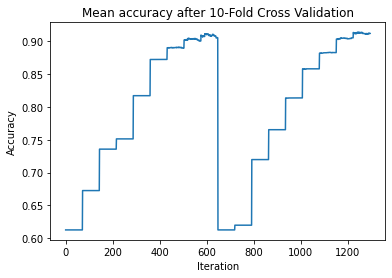

In [138]:
test_scores = dtree.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [68]:
#accuracy = dtree.score(X_test, y_test) 
#print('Accuracy: {0:.2%}'.format(accuracy))

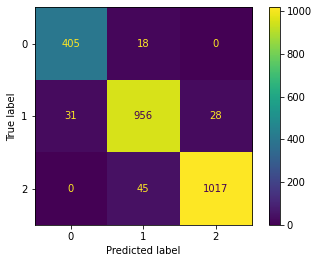

In [136]:
plot_confusion_matrix(dtree, X_test, y_test)  
plt.show()

## Export

In [139]:
r = export_text(dtree.best_estimator_, feature_names=features)
print(r)

#dump(dtree, MODEL_OUTPUT_PATH + 'Tree_classifier.joblib') 

|--- External Advisor <= 0.50
|   |--- Employee Training <= 0.50
|   |   |--- Successful Attacks <= 21.50
|   |   |   |--- Known Vulnerabilities <= 6.50
|   |   |   |   |--- Known Vulnerabilities <= 1.50
|   |   |   |   |   |--- Successful Attacks <= 10.50
|   |   |   |   |   |   |--- Invested Amount <= 678281.50
|   |   |   |   |   |   |   |--- Known Vulnerabilities <= 0.50
|   |   |   |   |   |   |   |   |--- Successful Attacks <= 3.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Successful Attacks >  3.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Known Vulnerabilities >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Invested Amount >  678281.50
|   |   |   |   |   |   |   |--- Successful Attacks <= 6.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Successful Attacks >  6.50
|   |   |   |   |   |   |   |   |--- Known Vulnerabilities <=

## Prediction

In [140]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1077113,8,29,4947796,57879,1,6,0


In [171]:
predicted_risk = dtree.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# Support Vector Machine (SVM) classifier

In [172]:
from sklearn.svm import LinearSVC, SVC 

In [ ]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

## Parameter Tuning (with K-Fold Cross Validation)

In [173]:
# Define the parameter ranges that should be tested on the model
svm_params = {
    'kernel': ["poly", "rbf", "sigmoid"],
    'gamma': ["scale", "auto"]
}

# Instanciate the Grid for parameter tuning
svm_grid = GridSearchCV(SVC(), svm_params, cv=10, scoring='accuracy', n_jobs=-1)

svm = svm_grid.fit(X_normalized, Y)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [174]:
pd.DataFrame(svm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.358150,0.031652,0.030355,0.007551,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",0.981,0.984,0.984,0.984,0.982,0.980,0.985,0.975,0.987,0.984,0.9826,0.003169,1
1,0.825914,0.053131,0.240829,0.018714,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",0.979,0.963,0.978,0.988,0.977,0.984,0.982,0.978,0.978,0.975,0.9782,0.006226,2
2,2.973521,0.287113,0.323203,0.030764,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",0.398,0.424,0.418,0.436,0.434,0.498,0.453,0.429,0.439,0.423,0.4352,0.025039,6
3,1.659002,0.152800,0.201300,0.018509,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",0.901,0.894,0.915,0.894,0.910,0.920,0.924,0.895,0.902,0.922,0.9077,0.011376,4
4,1.280386,0.068541,0.417284,0.011500,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",0.945,0.943,0.954,0.953,0.937,0.952,0.961,0.940,0.952,0.960,0.9497,0.007721,3


In [175]:
print(svm.best_estimator_)
print(svm.best_params_)
print('Best Accuracy: {0:.2%}'.format(svm.best_score_))

SVC(kernel='poly')
{'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 98.26%


## (Train - using Test-Train Split)

In [452]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

#start = time.time()

#svm.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time for polynomial SVM: {stop - start}s")

## Evaluate

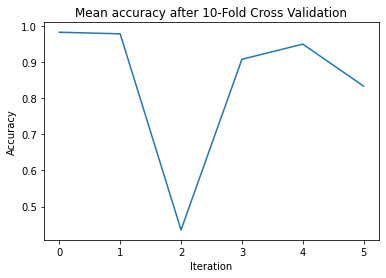

In [176]:
test_scores = svm.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#accuracy = svm_model.score(X_test_normalized, y_test) 

#print('Accuracy: {0:.2%}'.format(accuracy))

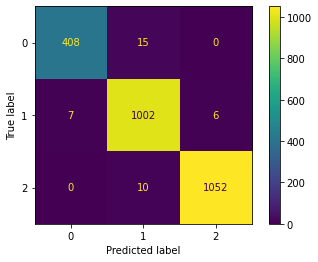

In [177]:
plot_confusion_matrix(svm, X_test_normalized, y_test)  
plt.show()

## Export

In [549]:
dump(svm, MODEL_OUTPUT_PATH + 'SVM_classifier.joblib') 

['../src/models/SVM_classifier.joblib']

## Prediction

In [178]:
predicted_risk = svm.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# K-nearest Neighbours Classifier

In [179]:
from sklearn.neighbors import KNeighborsClassifier

In [189]:
knn = KNeighborsClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [190]:
# Define the parameter ranges that should be tested on the model
knn_params = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance']
}

# Instanciate the Grid for parameter tuning
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring='accuracy', n_jobs=-1)

knn = knn_grid.fit(X_normalized, Y)

In [191]:
pd.DataFrame(knn.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015875,0.005984,0.042440,0.005095,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.905,0.902,0.904,0.907,0.906,0.924,0.920,0.919,0.900,0.917,0.9104,0.008212,55
1,0.011870,0.002204,0.017256,0.005695,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.905,0.902,0.904,0.907,0.906,0.924,0.920,0.919,0.900,0.917,0.9104,0.008212,55
2,0.014714,0.007545,0.039812,0.007163,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.887,0.895,0.906,0.888,0.906,0.911,0.901,0.903,0.906,0.901,0.9004,0.007592,58
3,0.013372,0.005111,0.017877,0.005836,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.905,0.902,0.904,0.907,0.906,0.924,0.920,0.919,0.900,0.917,0.9104,0.008212,55
4,0.014095,0.005123,0.039061,0.006136,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.915,0.926,0.929,0.926,0.919,0.924,0.920,0.930,0.920,0.933,0.9242,0.005363,53


In [192]:
print(knn.best_estimator_)
print(knn.best_params_)
print('Best Accuracy: {0:.2%}'.format(knn.best_score_))

KNeighborsClassifier(n_neighbors=21, weights='distance')
{'n_neighbors': 21, 'weights': 'distance'}
Best Accuracy: 93.76%


## (Train - using Test-Train Split)

In [130]:
#start = time.time()

#knn.fit(X_train_normalized, y_train) 

#stop = time.time()
#print(f"Training time KNN Classifier: {stop - start}s")

Training time KNN Classifier: 0.0075609683990478516s


## Evaluate

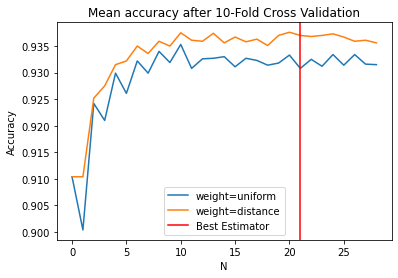

In [194]:
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 10-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=knn.best_params_['n_neighbors'], label='Best Estimator', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [187]:
#accuracy = knn.score(X_test_normalized, y_test) 
#print('Accuracy: {0:.2%}'.format(accuracy))

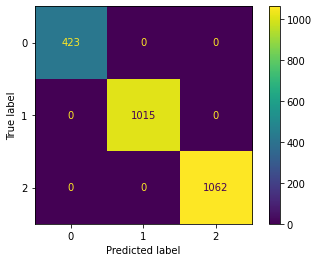

In [195]:
plot_confusion_matrix(knn, X_test_normalized, y_test)  
plt.show()

## Export

In [559]:
dump(knn, MODEL_OUTPUT_PATH + 'KNN_classifier.joblib') 

['../src/models/KNN_classifier.joblib']

## Prediction

In [196]:
predicted_risk = knn.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# Multilayer Perceptron (MLP) using Backpropagation

In [14]:
from sklearn.neural_network import MLPClassifier

In [15]:
#clf = MLPClassifier(activation='tanh', solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=10000)

mlp = MLPClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [16]:
mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 2)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=10, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_normalized, Y)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [17]:
mlp_result = pd.DataFrame(mlp.cv_results_)

mlp_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.059636,0.052553,0.001217,0.000587,logistic,"(5, 2)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.972,...,0.989,0.978,0.935,0.959,0.988,0.987,0.970,0.9696,0.018304,6
1,0.459977,0.046644,0.000842,0.000644,logistic,"(5, 2)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.425,...,0.425,0.426,0.426,0.425,0.425,0.425,0.425,0.4252,0.000400,24
2,3.837968,0.095261,0.001260,0.000483,logistic,"(5, 2)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.906,...,0.887,0.876,0.899,0.897,0.911,0.920,0.910,0.9008,0.014593,15
3,0.985229,0.034561,0.001253,0.001734,logistic,"(5, 2)",invscaling,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.913,...,0.931,0.928,0.949,0.946,0.987,0.949,0.924,0.9460,0.022095,10
4,0.365024,0.193508,0.000733,0.000639,logistic,"(5, 2)",invscaling,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.425,...,0.397,0.396,0.396,0.396,0.179,0.425,0.396,0.3804,0.068074,26


In [18]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 2), solver='lbfgs')
{'activation': 'tanh', 'hidden_layer_sizes': (5, 2), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best Accuracy: 98.03%


## (Train - Using Test-Train Split)

In [322]:
#start = time.time()

#mlp.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time MLP Classifier: {stop - start}s")

## Evaluate

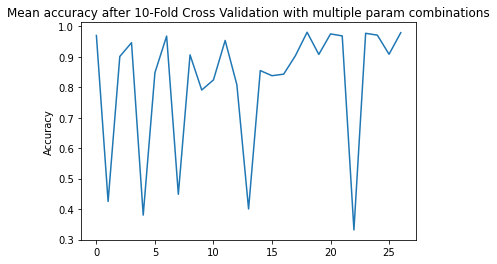

In [19]:
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(test_scores)
plt.ylabel("Accuracy")
plt.show()

In [373]:
#from sklearn.model_selection import cross_val_score


#accuracy = clf.score(X_test_normalized, y_test) 

#print('Accuracy: {0:.2%}'.format(accuracy))

# lbfgs
# identity -> 90.72%
# logistic -> 98.88%
# tanh -> 99.68%
# relu -> 62.08%


# sgd
# identity -> 90.48%
# logistic -> 62.08%
# tanh -> 98.24%
# relu -> 62.08%

# adam
# identity -> 90.88%
# logistic -> 98.48%
# tanh -> 99.04%
# relu -> 98.88%

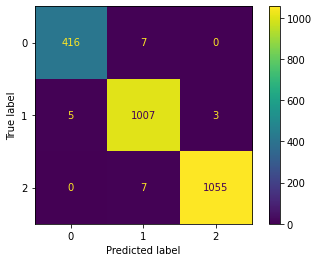

In [205]:
plot_confusion_matrix(mlp, X_test_normalized, y_test)  
plt.show()

In [ ]:
X = scaler.transform(data[features])
Y = data["Risk"]
plot_learning_curve(mlp, X, Y)

## Export

In [563]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_classifier.joblib') 

['../src/models/MLP_classifier.joblib']

## Prediction

In [24]:
predicted_risk = mlp.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW
[0]


# Benchmarking

In [93]:
dataset_entries = [5000, 10000, 25000, 50000, 100000]
dt_accuracy_list = []
svm_accuracy_list = []
knn_accuracy_list = []
mlp_accuracy_list = []

dt_training_times = []
svm_training_times = []
knn_training_times = []
mlp_training_times = []

In [94]:
for nr_of_entries in dataset_entries:
    data = generate_data(nr_of_entries)
    data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})
    
    X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)
    
    # Decision Tree
    dtree_model = DecisionTreeClassifier()
    start = time.time()
    dtree_model.fit(X_train, y_train) 
    stop = time.time()
    dt_training_times.append(stop - start)
    dt_accuracy_list.append(dtree_model.score(X_test, y_test))
                            
    # Scaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # SVM
    svm_model = SVC(kernel='poly')
    start = time.time()
    svm_model.fit(X_train_normalized, y_train)
    stop = time.time()
    svm_training_times.append(stop - start)
    svm_accuracy_list.append(svm_model.score(X_test_normalized, y_test))
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 17)
    start = time.time()
    knn.fit(X_train_normalized, y_train) 
    stop = time.time()
    knn_training_times.append(stop - start)
    knn_accuracy_list.append(knn.score(X_test_normalized, y_test))
    
    # MLP
    clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=100000)
    start = time.time()
    clf.fit(X_train_normalized, y_train)
    stop = time.time()
    mlp_training_times.append(stop - start)
    mlp_accuracy_list.append(clf.score(X_test_normalized, y_test))
    

In [100]:
print(dataset_entries)
print("\n Accuracy:")
print("Decision Tree: " + str(dt_accuracy_list))
print(svm_accuracy_list)
print(knn_accuracy_list)
print(mlp_accuracy_list)

print("\n Training Times:")
print(dt_training_times)
print(svm_training_times)
print(knn_training_times)
print(mlp_training_times)

[5000, 10000, 25000, 50000, 100000]

 Accuracy:
Decision Tree: [0.8784, 0.9048, 0.92896, 0.93928, 0.9508]
[0.9664, 0.9772, 0.98528, 0.98728, 0.98984]
[0.9168, 0.9332, 0.9496, 0.95544, 0.96436]
[0.9888, 0.9972, 0.99824, 0.97256, 0.9992]

 Training Times:
[0.010490179061889648, 0.0204160213470459, 0.05765199661254883, 0.12712311744689941, 0.3110668659210205]
[0.06813311576843262, 0.19890880584716797, 0.8305602073669434, 3.1285979747772217, 12.188233137130737]
[0.0017361640930175781, 0.004775047302246094, 0.0270688533782959, 0.054738759994506836, 0.365800142288208]
[8.24178409576416, 11.813431978225708, 30.678292989730835, 13.996891021728516, 540.4573841094971]
